In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import missingno as msno
from pandasql import sqldf
import sys
sys.path.insert(0,'../../src')
from statistiske_maal import beregne_statistiske_verdier
from plot_funksjon import plott_smart_scatter

In [45]:
file_path_3 = os.path.join("../..", "data", "filtered_data_Saturday.csv")

df = pd.read_csv(file_path_3)

kolonner = ['Temperatur (°C)', 'Vindhastighet (km/t)', 'Trykk', 'Nedbør (mm)']

beregne_statistiske_verdier(df, kolonner)


Temperatur (°C)
 Gjennomsnitt: 1.82
 Median 3.20
 Standardavvik: 3.59

Vindhastighet (km/t)
 Gjennomsnitt: 12.21
 Median 6.80
 Standardavvik: 10.39

Trykk
 Gjennomsnitt: 1015.32
 Median 1018.00
 Standardavvik: 18.43

Nedbør (mm)
 Gjennomsnitt: 0.12
 Median 0.00
 Standardavvik: 0.31



In [11]:
file_path_4 = os.path.join("../..", "data", "trondheim_vaerdata_full_1.csv")

df = pd.read_csv(file_path_4)

#print(df.dtypes)

df['Tidspunkt'] = pd.to_datetime(df['Tidspunkt'])
df['weekday'] = df['Tidspunkt'].dt.strftime('%A')
df['hour'] = df['Tidspunkt'].dt.hour
 
filtered_df = df[(df['weekday'].isin(['Saturday'])) & (df['hour'] == 10)]




In [ ]:
#Manipulerer dataene effektivt med pandas sql

file_path_5 = os.path.join("../..", "data", "trondheim_vaerdata_full_1.csv")
df = pd.read_csv(file_path_5)



df["Dato"] = pd.to_datetime(df["Tidspunkt"]).dt.date
df_dager = df.groupby("Dato").agg({
    "Temperatur (°C)" : "mean",
    "Vindhastighet (km/t)" : "mean",
    "Nedbør (mm)" : "mean"
}).reset_index()

df_isbading = df_dager[
    (df_dager["Temperatur (°C)"].between(-5, 2)) & 
    (df_dager["Nedbør (mm)"] == 0) &
    (df_dager["Vindhastighet (km/t)"] < 6) 
    ]

print(df_isbading)




          Dato  Temperatur (°C)  Vindhastighet (km/t)  Nedbør (mm)
12  2025-01-28        -0.345833              5.766667          0.0
26  2025-02-11        -2.570833              4.829167          0.0
27  2025-02-12        -1.308333              4.033333          0.0
28  2025-02-13        -2.983333              5.645833          0.0
55  2025-03-12        -3.133333              3.879167          0.0


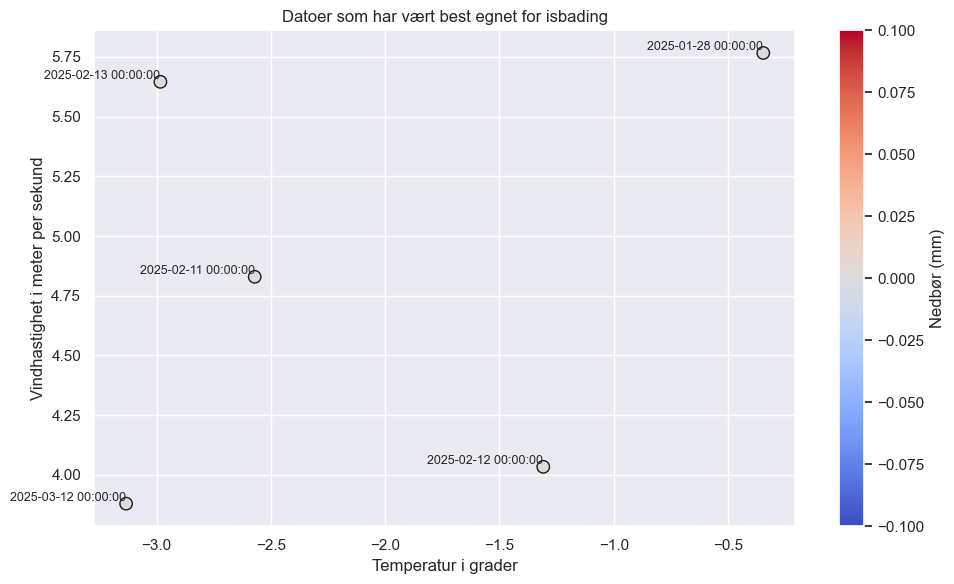

In [48]:
plott_smart_scatter(
    df = df_isbading,
    x_col = "Temperatur (°C)",
    y_col = "Vindhastighet (km/t)", 
    color_col = "Nedbør (mm)", 
    x_label = "Temperatur i grader",
    y_label = "Vindhastighet i meter per sekund",
    title= "Datoer som har vært best egnet for isbading", 
    colorbar_label = "Nedbør (mm)", 
    text_labels_col = "Dato"
)

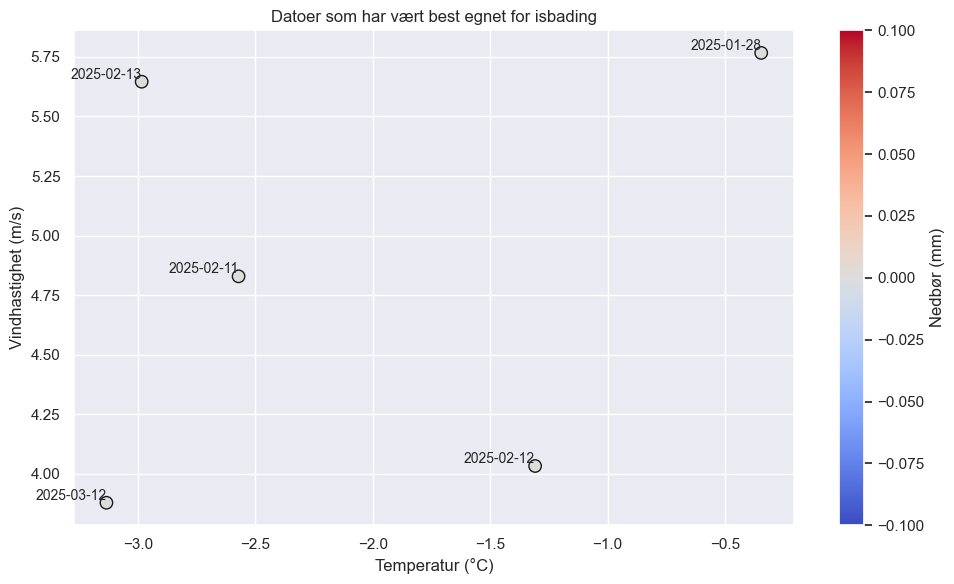

Index(['Dato', 'Temperatur (°C)', 'Vindhastighet (km/t)', 'Nedbør (mm)'], dtype='object')


In [46]:
plt.figure(figsize=(10, 6))
plt.scatter(df_isbading["Temperatur (°C)"],
            df_isbading["Vindhastighet (km/t)"],
            c=df_isbading["Nedbør (mm)"],
            cmap="coolwarm",
            s=80, #størrrelse på punktprikken
            edgecolors="k")

plt.xlabel("Temperatur (°C)")
plt.ylabel("Vindhastighet (m/s)")
plt.title("Datoer som har vært best egnet for isbading")
plt.colorbar(label="Nedbør (mm)")
plt.grid(True)

for i, row in df_isbading.iterrows():
    plt.text(row["Temperatur (°C)"], row["Vindhastighet (km/t)"],
            str(row["Dato"].strftime("%Y-%m-%d")), fontsize=10, ha="right", va="bottom")

plt.tight_layout()
plt.show()

print(df_isbading.columns)

C:\Users\eriks\AppData\Local\Temp\ipykernel_15392\3581572670.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_isbading['Dato'] = pd.to_datetime(df_isbading['Dato'])


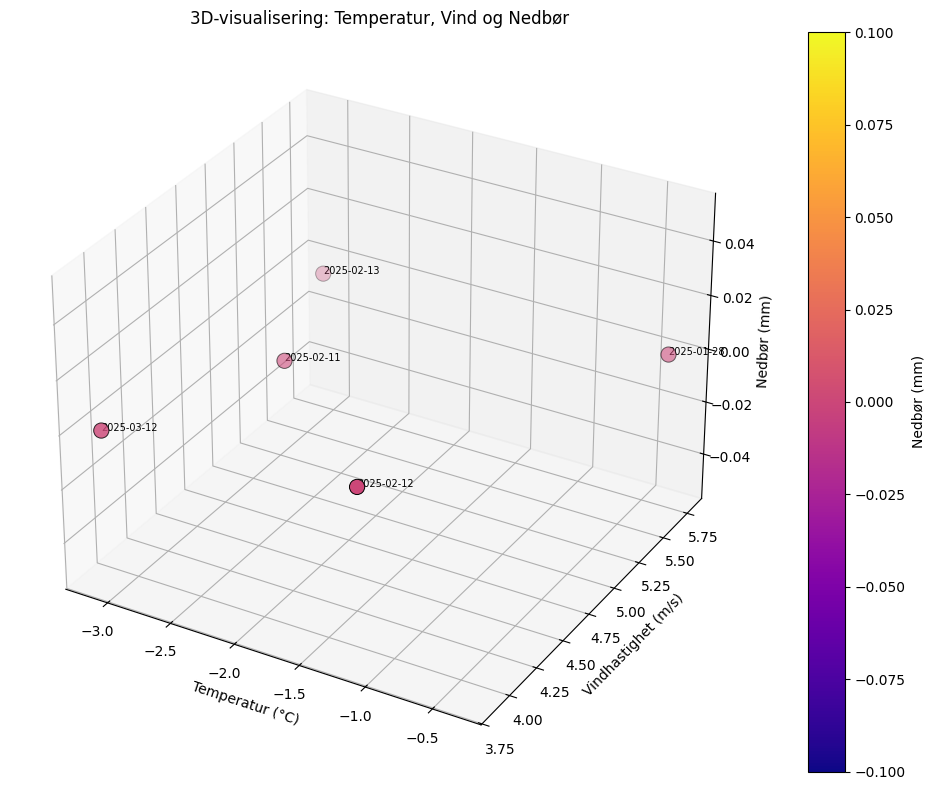

In [14]:
# Lage plottet som #D for å få opp datoene mere oversiktlig ifht nedbør, vind og temperatur
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

x = df_isbading["Temperatur (°C)"]
y = df_isbading["Vindhastighet (km/t)"]
z = df_isbading["Nedbør (mm)"]
df_isbading['Dato'] = pd.to_datetime(df_isbading['Dato'])
labels = df_isbading['Dato'].dt.strftime("%Y-%m-%d")



# Legger til en tydelig farge slik punketene viser tydelig, fargen endrer seg etter nedbørskalen, altså jo mindre vind
scatter = ax.scatter(x, y, z, 
                     c=z, 
                     cmap="plasma",   
                     s=120,           # større storleik på prikkene / punktet
                     edgecolors="black", 
                     linewidths=0.7)

# Legge til datoene på punktet
for i in range(len(df_isbading)):
    ax.text(x.iloc[i], y.iloc[i], z.iloc[i], labels.iloc[i], size=7, zorder=1)

# titler på aksene
ax.set_xlabel("Temperatur (°C)")
ax.set_ylabel("Vindhastighet (m/s)")
ax.set_zlabel("Nedbør (mm)")
ax.set_title("3D-visualisering: Temperatur, Vind og Nedbør")

# Farge på kolonna med nedbør
fig.colorbar(scatter, label="Nedbør (mm)")

plt.tight_layout()
plt.show()



<Axes: xlabel='Tidspunkt', ylabel='Måling'>

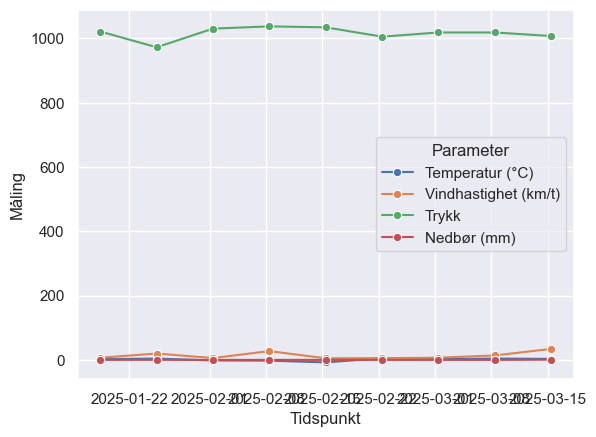

In [15]:
#Lager plots med seaborn i stedet for matplotlib

sns.set_theme(style="darkgrid")

df_melted = filtered_df.melt(id_vars=['Tidspunkt'],
                             value_vars=['Temperatur (°C)', 'Vindhastighet (km/t)', 'Trykk', 'Nedbør (mm)'], 
                             var_name='Parameter', 
                             value_name='Måling')

sns.lineplot(data=df_melted, x = 'Tidspunkt', y = 'Måling', hue='Parameter', marker="o")




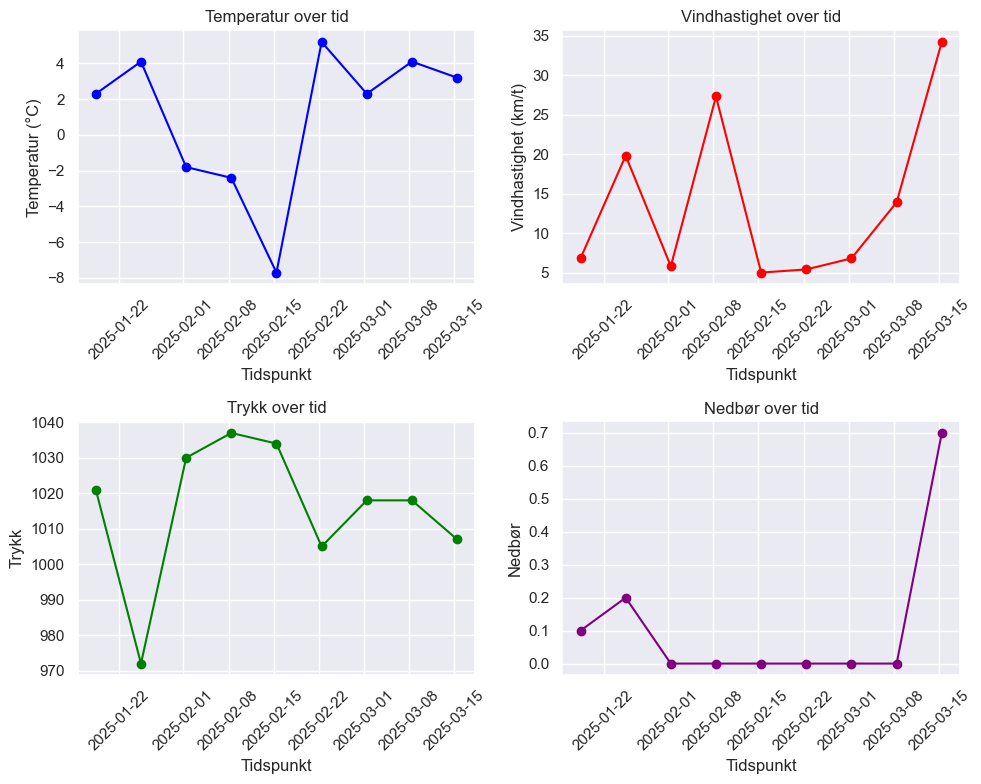

In [16]:
#Lager plots

filtered_df['Tidspunkt'] = pd.to_datetime(filtered_df['Tidspunkt'])

plt.figure(figsize=(10, 8))

#Temperatur
plt.subplot(2, 2, 1)
plt.plot(filtered_df['Tidspunkt'], filtered_df['Temperatur (°C)'], color='blue', marker="o", linestyle="-")
plt.xlabel("Tidspunkt")
plt.ylabel("Temperatur (°C)")
plt.title("Temperatur over tid")
plt.xticks(rotation = 45)

#Vindhastighet
plt.subplot(2, 2, 2)
plt.plot(filtered_df['Tidspunkt'], filtered_df['Vindhastighet (km/t)'], color='red', marker="o", linestyle="-")
plt.xlabel("Tidspunkt")
plt.ylabel("Vindhastighet (km/t)")
plt.title("Vindhastighet over tid")
plt.xticks(rotation = 45)


#Plot for trykk
plt.subplot(2, 2, 3)
plt.plot(filtered_df['Tidspunkt'], filtered_df['Trykk'], color='green', marker="o", linestyle="-")
plt.xlabel("Tidspunkt")
plt.ylabel("Trykk")
plt.title("Trykk over tid")
plt.xticks(rotation = 45)


#Plot for nedbør
plt.subplot(2, 2, 4)
plt.plot(filtered_df['Tidspunkt'], filtered_df['Nedbør (mm)'], color='purple', marker="o", linestyle="-")
plt.xlabel("Tidspunkt")
plt.ylabel("Nedbør")
plt.title("Nedbør over tid")
plt.xticks(rotation = 45)


plt.tight_layout()
plt.show()

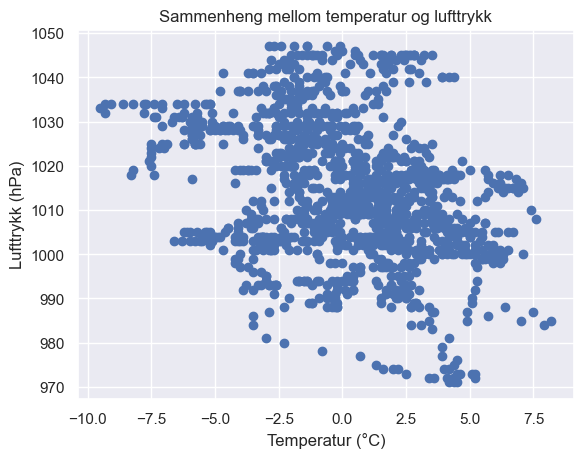

In [17]:
#Dataanalyse mellom temperatur og trykk
import matplotlib.pyplot as plt

plt.scatter(df['Temperatur (°C)'], df['Trykk'])
plt.xlabel("Temperatur (°C)")
plt.ylabel("Lufttrykk (hPa)")
plt.title("Sammenheng mellom temperatur og lufttrykk")
plt.show()

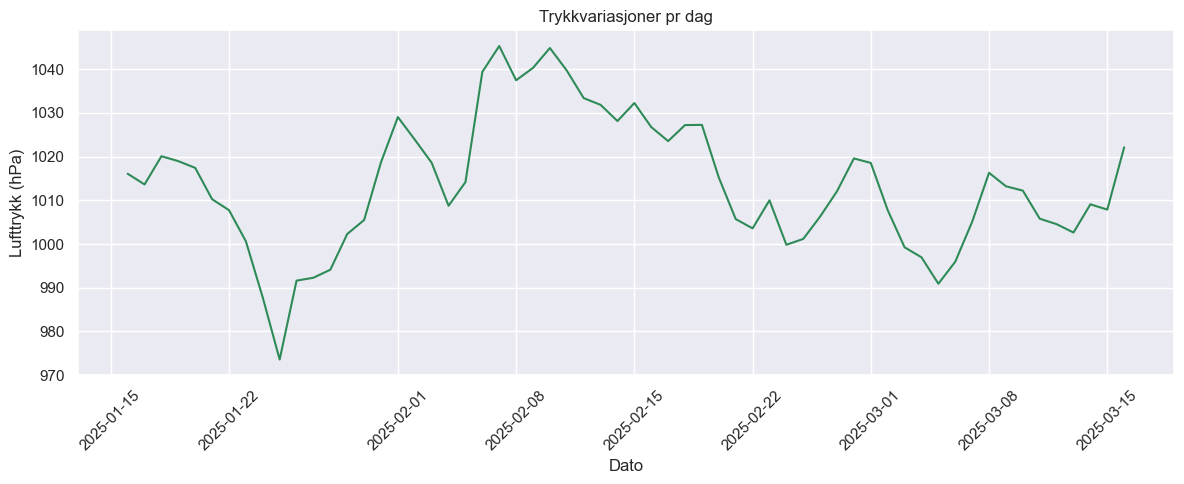

In [34]:
#linjeplott for trykkvariasjoner per dag

file_path_6 = os.path.join("../..", "data", "trondheim_vaerdata_full_1.csv")
df = pd.read_csv(file_path_6)
df["Tidspunkt"] = pd.to_datetime(df["Tidspunkt"])
df = df.sort_values("Tidspunkt")

df = df.set_index("Tidspunkt")
df_daglig = df.select_dtypes(include='number').resample('D').mean().reset_index()


plt.figure(figsize=(12, 5))

plt.plot(df_daglig['Tidspunkt'], df_daglig['Trykk'], color = 'seagreen')
plt.xlabel("Dato")
plt.ylabel("Lufttrykk (hPa)")
plt.title("Trykkvariasjoner pr dag")
plt.grid(True)
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()



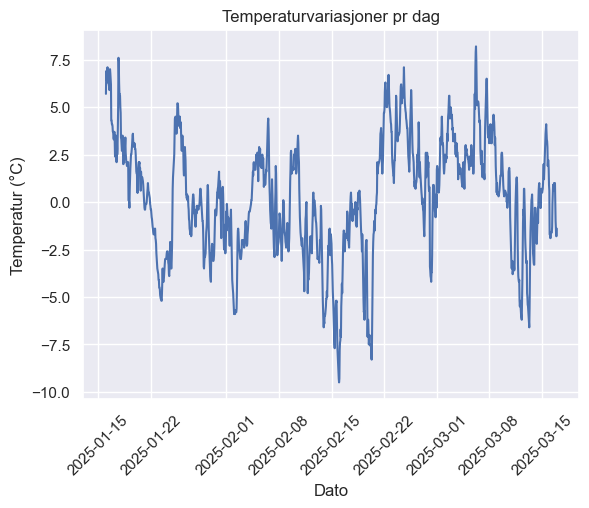

In [37]:
#linjeplott for temperaturvariasjoner per dag

plt.plot(df.index, df['Temperatur (°C)'])
plt.xlabel("Dato")
plt.ylabel("Temperatur (°C)")
plt.title("Temperaturvariasjoner pr dag")
plt.xticks(rotation = 45)
plt.show()

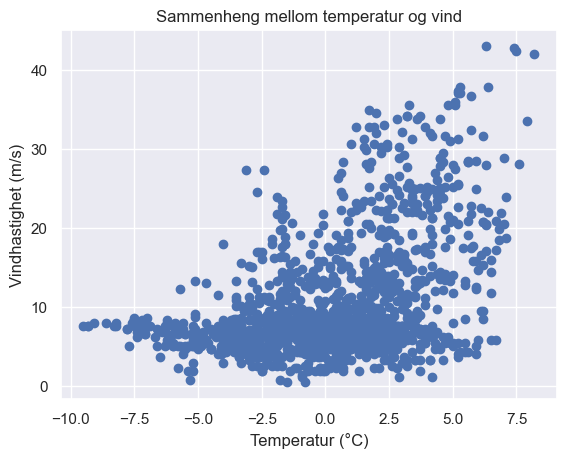

In [20]:
#scatterplot for temperatur vs vind

plt.scatter(df['Temperatur (°C)'], df['Vindhastighet (km/t)'])
plt.xlabel("Temperatur (°C)")
plt.ylabel("Vindhastighet (m/s)")
plt.title("Sammenheng mellom temperatur og vind")
plt.show()

In [ ]:
#Lag Readme filer 
#Lag source filer
#Lag test filer
#Sjekk opp branches


#Lukker filressurser på en trygg måte
#beregne statistiske mål som gjennomsnitt og standardavvik
#Widgets, Plotly eller Bokeh
#Bading/isbading


